In [1]:
%matplotlib inline
from copy import deepcopy as copy
import json
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.sparse import csc_matrix

from aux import Generic
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks, set_color

cc = np.concatenate


LOAD_PRFX = 'PARAM_SWEEP_RESULTS'
SAVE_PRFX = 'PARAM_SWEEP_RESULTS_EXT'

# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.05, 'V_TH_PC': -0.036, 'V_R_PC': -0.05, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1500,
    'W_PC_PC': .026, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .3,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.005, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 150,
    'W_INH_PC': 0.005, 'W_PC_INH': 0.0002,
    
    # gating inputs
    'W_PC_G': 0, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 200, 
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": .5, "BOX_W": 4, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-2, 0), (2, 0)],
    
    'TRG': [
        {'T': 0.15, 'A': 0.01, 'R': 0.15, 'D': 0.002, 'X': -2, 'Y': 0},
    ],
    
    'D_SMLN': 1,
}

In [2]:
def join_w(targs, srcs, ws):
    """
    Combine multiple weight matrices specific to pairs of populations
    into a single, full set of weight matrices (one per synapse type).
    
    :param targs: dict of boolean masks indicating targ cell classes
    :param srcs: dict of boolean masks indicating source cell classes
    :param ws: dict of inter-population weight matrices, e.g.:
        ws = {
            'AMPA': {
                ('EXC', 'EXC'): np.array([[...]]),
                ('INH', 'EXC'): np.array([[...]]),
            },
            'GABA': {
                ('EXC', 'INH'): np.array([[...]]),
                ('INH', 'INH'): np.array([[...]]),
            }
        }
        note: keys given as (targ, src)
    
    :return: ws_full, a dict of full ws, one per synapse
    """
    # convert targs/srcs to dicts if given as arrays
    if not isinstance(targs, dict):
        targs_ = copy(targs)
        targs = {
            cell_type: targs_ == cell_type for cell_type in set(targs_)
        }
    if not isinstance(srcs, dict):
        srcs_ = copy(srcs)
        srcs = {
            cell_type: srcs_ == cell_type for cell_type in set(srcs_)
        }
        
    # make sure all targ/src masks have same shape
    targ_shapes = [mask.shape for mask in targs.values()]
    src_shapes = [mask.shape for mask in srcs.values()]
    
    if len(set(targ_shapes)) > 1:
        raise Exception('All targ masks must have same shape.')
        
    if len(set(src_shapes)) > 1:
        raise Exception('All targ masks must have same shape.')
        
    n_targ = targ_shapes[0][0]
    n_src = src_shapes[0][0]
    
    # make sure weight matrix dimensions match sizes
    # of targ/src classes
    for syn, ws_ in ws.items():
        for (targ, src), w_ in ws_.items():
            if not w_.shape == (targs[targ].sum(), srcs[src].sum()):
                raise Exception(
                    'Weight matrix for {}: ({}, {}) does not match '
                    'dimensionality specified by targ/src masks.')
        
    # loop through synapse types
    dtype = list(list(ws.values())[0].values())[0].dtype
    ws_full = {}
    
    for syn, ws_ in ws.items():
        
        w = np.zeros((n_targ, n_src), dtype=dtype)
        
        # loop through population pairs
        for (targ, src), w_ in ws_.items():
            
            # get mask of all cxns from src to targ
            mask = np.outer(targs[targ], srcs[src])
            
            assert mask.sum() == w_.size
            
            w[mask] = w_.flatten()
            
        ws_full[syn] = w
        
    return ws_full


# NETWORK CLASS AND FUNCTIONS

class LIFNtwk(object):
    """
    Network of leaky integrate-and-fire (LIF) neurons.
    All parameters should be given in SI units
    (i.e., time constants in seconds, potentials in volts).
    This simulation uses exponential
    synapses for all synapse types.

    In all weight matrices, rows index target, cols index source.
    
    :param t_m: membrane time constant (or 1D array)
    :param e_l: leak reversal potential (or 1D array)
    :param v_th: firing threshold potential (or 1D array)
    :param v_r: reset potential (or 1D array)
    :param t_r: refractory time
    :param es_syn: synaptic reversal potentials (dict with keys naming
        synapse types, e.g., 'AMPA', 'NMDA', ...)
    :param ts_syn: synaptic time constants (dict)
    :param ws_rcr: recurrent synaptic weight matrices (dict with keys
        naming synapse types)
    :param ws_up: input synaptic weight matrices from upstream inputs (dict)
    :param sparse: whether to convert weight matrices to sparse matrices for
        more efficient processing
    """
    
    def __init__(self,
            t_m, e_l, v_th, v_r, t_r,
            es_syn=None, ts_syn=None, ws_up=None, ws_rcr=None, 
            sparse=True):
        """Constructor."""

        # validate arguments
        if es_syn is None:
            es_syn = {}
        if ts_syn is None:
            ts_syn = {}
        if ws_up is None:
            ws_up = {}
        if ws_rcr is None:
            ws_rcr = {}

        self.syns = list(es_syn.keys())
        
        # check weight matrices have correct dims
        shape_rcr = list(ws_rcr.values())[0].shape
        shape_up = list(ws_up.values())[0].shape
        
        self.n = shape_rcr[1]

        # fill in unspecified weight matrices with zeros
        for syn in self.syns:
            if syn not in ws_rcr:
                ws_rcr[syn] = np.zeros(shape_rcr)
            if syn not in ws_up:
                ws_up[syn] = np.zeros(shape_up)
        
        # check syn. dicts have same keys
        if not set(es_syn) == set(ts_syn) == set(ws_rcr) == set(ws_up):
            raise ValueError(
                'All synaptic dicts ("es_syn", "ts_syn", '
                '"ws_rcr", "ws_inp") must have same keys.'
            )

        if not all([w.shape[0] == w.shape[1] == self.n for w in ws_rcr.values()]):
            raise ValueError('All recurrent weight matrices must be square.')

        # check input matrices' have correct dims
        self.n_up = list(ws_up.values())[0].shape[1]

        if not all([w.shape[0] == self.n for w in ws_up.values()]):
            raise ValueError(
                'Upstream weight matrices must have one row per neuron.')

        if not all([w.shape[1] == self.n_up for w in ws_up.values()]):
            raise ValueError(
                'All upstream weight matrices must have same number of columns.')

        # make sure v_r is actually an array
        if isinstance(v_r, (int, float, complex)):
            v_r = v_r * np.ones(self.n)
            
        # store network params
        self.t_m = t_m
        self.e_l = e_l
        self.v_th = v_th
        self.v_r = v_r
        self.t_r = t_r
        
        self.es_syn = es_syn
        self.ts_syn = ts_syn
        
        if sparse:
            ws_rcr = {syn: csc_matrix(w) for syn, w in ws_rcr.items()}
            ws_up = {syn: csc_matrix(w) for syn, w in ws_up.items()}
            
        self.ws_rcr = ws_rcr
        self.ws_up = ws_up
        
    def run(self, spks_up, dt, vs_0=None, gs_0=None, i_ext=None, store=None, report_every=None):
        """
        Run a simulation of the network.

        :param spks_up: upstream spiking inputs (rows are time points, 
            cols are neurons) (should be non-negative integers)
        :param dt: integration time step for dynamics simulation
        :param vs_0: initial vs
        :param gs_0: initial gs (dict of 1-D arrays)
            are time points, cols are neurons)

        :return: network response object
        """

        # validate arguments
        if vs_0 is None:
            vs_0 = self.e_l * np.ones(self.n)
        if gs_0 is None:
            gs_0 = {syn: np.zeros(self.n) for syn in self.syns}

        if not vs_0.shape == (self.n,):
            raise ValueError(
                '"vs_0" must be 1-D array with one element per neuron.')

        if not all([gs.shape == (self.n,) for gs in gs_0.values()]):
            raise ValueError(
                'All elements of "gs_0" should be 1-D array with '
                'one element per neuron.')

        if store is None:
            store = {}
        
        if 'vs' not in store:
            store['vs'] = np.float64
        if 'spks' not in store:
            store['spks'] = bool
        if 'gs' not in store:
            store['gs'] = np.float64
           
        for key, val in store.items():
            
            if key == 'vs':
                assert val in (None, float, np.float16, np.float64)
            elif key == 'gs':
                assert val in (None, float, np.float16, np.float64)
            elif key == 'spks':
                assert val in (None, bool)
            
        # prepare smln
        ts = np.arange(len(i_ext)) * dt
                  
        # initialize membrane potentials, conductances, and refractory counters
        vs_prev = vs_0.copy()
        spks_prev = np.zeros(vs_0.shape, dtype=bool)
        gs_prev = {syn: gs_0[syn].copy() for syn in self.syns}
        rp_ctrs = np.zeros(self.n)
                  
        # allocate space for slmn results and store initial values
        sim_shape = (len(ts), self.n)
        
        vs = None
        spks = None
        gs = None
        
        if (i_ext is None):
            i_ext = np.zeros(len(ts))
        
        if store['vs'] is not None:
            vs = np.nan * np.zeros(sim_shape, dtype=store['vs'])
            vs[0, :] = vs_prev.copy()
                  
        if store['spks'] is not None:
            spks = np.zeros(sim_shape, dtype=bool)
            spks[0, :] = spks_prev.copy()
                  
        if store['gs'] is not None:
            gs = {
                syn: np.nan * np.zeros(sim_shape, dtype=store['gs'])
                for syn in self.syns
            }
                  
            for syn in self.syns:
                gs[syn][0, :] = gs_0[syn].copy()
                  
        # run simulation
        
        for step in range(1, len(ts)):

            ## update dynamics
            for syn in self.syns:
                
                # calculate new conductances for all synapse types
                w_up = self.ws_up[syn]
                w_rcr = self.ws_rcr[syn]
                t_syn = self.ts_syn[syn]

                # calculate upstream and recurrent inputs to conductances
                if spks_up is not None:
                    inps_up = w_up.dot(spks_up[step])
                else:
                    inps_up = 0
                inps_rcr = w_rcr.dot(spks_prev)

                # decay conductances and add any positive inputs
                dg = -(dt/t_syn) * gs_prev[syn] + inps_up + inps_rcr
                gs_prev[syn] = gs_prev[syn] + dg
             
            # calculate current input resulting from synaptic conductances
            ## note: conductances are relative, so is_g are in volts
            is_g = [
                gs_prev[syn] * (self.es_syn[syn] - vs_prev)
                for syn in self.syns
            ]
            
            # get total input current
            is_all = np.sum(is_g, axis=0) + i_ext[step]
            
            # update membrane potential
            dvs = -(dt/self.t_m) * (vs_prev - self.e_l) + is_all
            vs_prev = vs_prev + dvs
            
            # force refractory neurons to reset potential
            vs_prev[rp_ctrs > 0] = self.v_r[rp_ctrs > 0]
            
            # identify spks
            spks_prev = vs_prev >= self.v_th
                  
            # reset membrane potentials of spiking neurons
            vs_prev[spks_prev] = self.v_r[spks_prev]
            
            # set refractory counters for spiking neurons
            rp_ctrs[spks_prev] = self.t_r[spks_prev]
            # decrement refractory counters for all neurons
            rp_ctrs -= dt
            # adjust negative refractory counters up to zero
            rp_ctrs[rp_ctrs < 0] = 0
                 
            # store vs
            if store['vs'] is not None:
                vs[step] = vs_prev.copy()
            
            # store spks
            if store['spks'] is not None:
                spks[step] = spks_prev.copy()

            # store conductances
            if store['gs'] is not None:
                for syn in self.syns:
                    gs[syn][step] = gs_prev[syn].copy()
                 
        # return NtwkResponse object
        return NtwkResponse(
            ts=ts, vs=vs, spks=spks, spks_up=spks_up, dt=dt, i_ext=i_ext, e_l=self.e_l, v_th=self.v_th,
            gs=gs, ws_rcr=self.ws_rcr, ws_up=self.ws_up)

    
class NtwkResponse(object):
    """
    Class for storing network response parameters.

    :param ts: timestamp vector
    :param vs: membrane potentials
    :param spks: spk times
    :param gs: syn-dict of conductances
    :param ws_rcr: syn-dict of recurrent weight matrices
    :param ws_up: syn-dict upstream weight matrices
    :param cell_types: array-like of cell-types
    :param cs: spk ctr variables for each cell
    :param ws_plastic: syn-dict of time-courses of plastic weights
    :param masks_plastic: syn-dict of masks specifying which weights the plastic
        ones correspond to
    :param pfcs: array of cell place field centers
    """

    def __init__(self, ts, vs, spks, spks_up, dt, i_ext, e_l, v_th, gs, ws_rcr, ws_up, cell_types=None, pfcs=None):
        """Constructor."""
        # check args
        if (cell_types is not None) and (len(cell_types) != vs.shape[1]):
            raise ValueError(
                'If "cell_types" is provided, all cells must have a type.')
            
        self.ts = ts
        self.vs = vs
        self.spks = spks
        self.spks_up = spks_up
        self.dt = dt
        self.i_ext = i_ext
        self.e_l = e_l
        self.v_th = v_th
        self.gs = gs
        self.ws_rcr = ws_rcr
        self.ws_up = ws_up
        self.cell_types = cell_types
        
        self.dt = np.mean(np.diff(ts))
        self.fs = 1 / self.dt
   
    @property
    def n(self):
        """Number of neurons."""
        return self.vs.shape[1]

In [3]:
def apx_lattice(lb, ub, n, randomize):
    """
    Arrange n points on an apx. lattice within a rectangle.
    (Apx. b/c rectangle dims may not evenly divide n.)
    """
    lb_x, lb_y = lb
    ub_x, ub_y = ub

    r_x = ub_x - lb_x
    r_y = ub_y - lb_y

    # get apx factors of n
    n_x = np.sqrt((r_x/r_y) * n)
    n_y = n/n_x

    # get # pts per row
    n_rows = int(np.round(n_y))
    n_pts = [len(row) for row in np.array_split(np.arange(n), n_rows)]

    # evenly distribute n_pts so that largest rows are not clumped at top
    if len(set(n_pts)) > 1:
        
        ## split into groups of same n_pts
        gp_0, gp_1 = [[ii for ii in n_pts if ii == i] for i in set(n_pts)]

        if len(gp_1) > len(gp_0):
            gp_0, gp_1 = gp_1, gp_0

        ## assign float "t" to each n_pt
        n_0 = len(gp_0)
        n_1 = len(gp_1)

        ts_0 = [k * (n - 1) / (n_0 - 1) for k in range(n_0)]
        ts_1 = [k * (n - 1) / (n_1 + 1) for k in range(1, n_1 + 1)]

        ts = cc([ts_0, ts_1])

        ## sort n_pts according to ts
        n_pts = cc([gp_0, gp_1])[np.argsort(ts)]
    
    # assign (x, y) positions
    ys_row = np.linspace(lb_y, ub_y, n_rows+2)[1:-1]

    xs = []
    ys = []

    ## add group of positions for each row
    for y_row, n_pts_ in zip(ys_row, n_pts):

        xs_ = list(np.linspace(lb_x, ub_x, n_pts_ + 2)[1:-1])
        ys_ = list(np.repeat(y_row, len(xs_)))

        xs.extend(xs_)
        ys.extend(ys_)
        
    xs = np.array(xs)
    ys = np.array(ys)
    
    if randomize:
        shuffle = np.random.permutation(n)
        
        xs = xs[shuffle]
        ys = ys[shuffle]

    return xs, ys


def _w_pc_pc_vs_d(d, p):
    """Return distance-dependent portion of w_pc_pc computation."""
    assert np.all(d >= 0)
    
    # decrease weights as squared exp of dist
    w = p['W_PC_PC'] * np.exp(-d**2/(2*p['L_PC_PC']**2))
    
    # set all weights below min weight th to 0
    w[w < p['W_MIN_PC_PC']] = 0
    
    return w


def make_w_pc_pc(pfxs, pfys, p):
    """Make PC-PC weight mat w/ weight increasing w/ proxim."""
    n_pc = p['N_PC']
    
    # build distance matrix
    dx = np.tile(pfxs[None, :], (n_pc, 1)) - np.tile(pfxs[:, None], (1, n_pc))
    dy = np.tile(pfys[None, :], (n_pc, 1)) - np.tile(pfys[:, None], (1, n_pc))
    d = np.sqrt(dx**2 + dy**2)
    
    # build weight matrix
    return _w_pc_pc_vs_d(d, p)
    

def make_w_inh_pc(pfxs_inh, pfys_inh, pfxs_pc, pfys_pc, p):
    """
    Make proximally biased PC->INH weight matrix.
    """
    n_inh = p['N_INH']
    n_pc = p['N_PC']
    
    # build weight matrix
    w_inh_pc = p['W_INH_PC'] * (np.random.rand(n_inh, n_pc) < 0.5).astype(float)
    return w_inh_pc
    
    
def make_w_pc_inh(pfxs_pc, pfys_pc, pfxs_inh, pfys_inh, p):
    """
    Make center-surround structured INH->PC weight matrix.
    """
    n_pc = p['N_PC']
    n_inh = p['N_INH']
    
    # build weight matrix
    w_pc_inh = p['W_PC_INH'] * (np.random.rand(n_pc, n_inh) < 0.5).astype(float)
    return w_pc_inh

In [4]:
def smln_run(p, s_params):
    """
    Run smln and return rslt.
    
    :param p: dict of model params
    :param s_params: dict of smln params
    """
    t = np.arange(0, s_params['D_SMLN'], s_params['DT'])
    
    ## build ntwk
    ntwk = build_ntwk(p, s_params)
   
    i_ext = build_stim(t, ntwk, p, s_params)
    
    # run smln
    rslt = ntwk.run(spks_up=None, dt=s_params['DT'], i_ext=i_ext)
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s_params['TRG']
    
    rslt.p = p
    rslt.s_params = s_params
    
    return rslt


def build_ntwk(p, s_params):
    """
    Construct a network object from the model and
    simulation params.
    """
    np.random.seed(s_params['RNG_SEED'])
    
    # set membrane properties
    n = p['N_PC'] + p['N_INH']
    
    t_m = cc(
        [np.repeat(p['T_M_PC'], p['N_PC']), np.repeat(p['T_M_INH'], p['N_INH'])])
    e_l = cc(
        [np.repeat(p['E_L_PC'], p['N_PC']), np.repeat(p['E_L_INH'], p['N_INH'])])
    v_th = cc(
        [np.repeat(p['V_TH_PC'], p['N_PC']), np.repeat(p['V_TH_INH'], p['N_INH'])])
    v_r = cc(
        [np.repeat(p['V_R_PC'], p['N_PC']), np.repeat(p['V_R_INH'], p['N_INH'])])
    t_rp = cc(
        [np.repeat(p['T_R_PC'], p['N_PC']), np.repeat(p['T_R_INH'], p['N_INH'])])
    
    # set latent nrn positions
    lb = [-s_params['BOX_W']/2, -s_params['BOX_H']/2]
    ub = [s_params['BOX_W']/2, s_params['BOX_H']/2]
    
    # sample evenly spaced place fields
    ## E cells
    pfxs_e, pfys_e = apx_lattice(lb, ub, p['N_PC'], randomize=True)
    ## I cells
    pfxs_i, pfys_i = apx_lattice(lb, ub, p['N_INH'], randomize=True)
    
    ## join E & I place fields
    pfxs = cc([pfxs_e, pfxs_i])
    pfys = cc([pfys_e, pfys_i])
       
    ws_up = {'E': np.zeros((p['N_PC'] + p['N_INH'], 0))}
    
    # make rcr ws
    w_pc_pc = make_w_pc_pc(pfxs[:p['N_PC']], pfys[:p['N_PC']], p)

    w_inh_pc = make_w_inh_pc(
        pfxs_inh=pfxs[-p['N_INH']:],
        pfys_inh=pfys[-p['N_INH']:],
        pfxs_pc=pfxs[:p['N_PC']],
        pfys_pc=pfys[:p['N_PC']],
        p=p)
    
    w_pc_inh = make_w_pc_inh(
        pfxs_pc=pfxs[:p['N_PC']],
        pfys_pc=pfys[:p['N_PC']],
        pfxs_inh=pfxs[-p['N_INH']:],
        pfys_inh=pfys[-p['N_INH']:],
        p=p)
    
    ws_rcr_temp = {
        'E': {
            ('PC', 'PC'): w_pc_pc,
            ('INH', 'PC'): w_inh_pc,
        },
        'I': {
            ('PC', 'INH'): w_pc_inh,
        },
    }
    targs_rcr = cc([np.repeat('PC', p['N_PC']), np.repeat('INH', p['N_INH'])])
    
    ws_rcr = join_w(targs_rcr, targs_rcr, ws_rcr_temp)
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=t_m,
        e_l=e_l,
        v_th=v_th,
        v_r=v_r,
        t_r=t_rp,
        es_syn={'E': p['E_E'], 'I': p['E_I']},
        ts_syn={'E': p['T_E'], 'I': p['T_I']},
        ws_up=ws_up,
        ws_rcr=ws_rcr)
    
    ntwk.pfxs = pfxs
    ntwk.pfys = pfys
    
    ntwk.types_rcr = targs_rcr
    
    ntwk.n_pc = p['N_PC']
    ntwk.n_inh = p['N_INH']
    ntwk.n_rcr = p['N_PC'] + p['N_INH']
    
    ntwk.types_rcr_slc = {
        'PC': slice(0, p['N_PC']),
        'INH': slice(p['N_PC'], p['N_PC'] + p['N_INH'])
    }
    
    return ntwk

       
def build_stim(t, ntwk, p, s_params):
    """
    Put together upstream spk and external current inputs
    according to stimulation params and schedule.
    """
    # initialize external current array
    i_ext = np.zeros((len(t), p['N_PC'] + p['N_INH']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, p, s_params)
    
    return i_ext


def i_ext_trg(t, ntwk, p, s_params):
    """
    Add replay trigger to external current stim.
    """
    i_ext = np.zeros((len(t), p['N_PC'] + p['N_INH']))
    
    # get mask over cells to trigger to induce replay
    for trg in s_params['TRG']:
        
        ## compute distances to trigger center
        trg_mask = get_trg_mask_pc(ntwk, p, trg)

        ## get time mask
        t_mask = (trg['T'] <= t) \
            & (t < (trg['T'] + trg['D']))

        ## add in external trigger
        i_ext[np.outer(t_mask, trg_mask)] = trg['A']

    return i_ext


def get_trg_mask_pc(ntwk, p, trg):
    """Get spatial mask for replay trigger."""
    dx = ntwk.pfxs - trg['X']
    dy = ntwk.pfys - trg['Y']
    d = np.sqrt(dx**2 + dy**2)
    
    ## get mask
    trg_mask = (d < trg['R']) & (ntwk.types_rcr == 'PC')
    
    return trg_mask

In [5]:
def get_idxs_nearest(xys, pfxs, pfys, nearest, colors):
    """
    Get ordered idxs of place fields nearest to a
    sequence of (x, y) points.
    """
    idxs = []
    c_dict_0 = {}
    c_dict_1 = []
    
    for xy, color in zip(xys, colors):
        # get dists of all PFs to (x, y)
        dx = pfxs - xy[0]
        dy = pfys - xy[1]
        d = np.sqrt(dx**2 + dy**2)
        
        # add idxs of closest neurons to list
        pcs = list(d.argsort()[:nearest])
        idxs.extend(pcs)
        
        for pc in pcs:
            c_dict_0[pc] = color
            
        c_dict_1.extend(len(pcs)*[color])
        
    return idxs, c_dict_0, np.array(c_dict_1)


def plot_spike_seq(rslt, epoch, cmap='gist_rainbow', sct_sz=25):
    """Plot spike count and order during specified epoch."""
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

    ## detection wdw
    start = epoch[0]
    end = epoch[1]

    t_mask = (start <= rslt.ts) & (rslt.ts < end)

    ## PC mask and PFs
    pc_mask = rslt.ntwk.types_rcr == 'PC'

    pfxs_pc = rslt.ntwk.pfxs[pc_mask]
    pfys_pc = rslt.ntwk.pfys[pc_mask]

    ## PC spk cts within detection window
    spks_wdw_pc = rslt.spks[t_mask][:, pc_mask]
    spk_ct_wdw_pc = spks_wdw_pc.sum(0)

    ## discrete colormap for showing spk cts
    c_map_tmp = plt.cm.jet
    c_map_list = [c_map_tmp(i) for i in range(c_map_tmp.N)]
    c_map_list[0] = (0., 0., 0., 1.)
    c_map = c_map_tmp.from_list('spk_ct', c_map_list, c_map_tmp.N)

    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = mpl.colors.BoundaryNorm(bounds, c_map.N)

    im_0 = axs[0].scatter(
        pfxs_pc, pfys_pc, c=spk_ct_wdw_pc, s=sct_sz, cmap=c_map, norm=norm)
    divider_0 = make_axes_locatable(axs[0])
    c_ax_0 = divider_0.append_axes('right', size='5%', pad=0.05)

    cb_0 = fig.colorbar(im_0, cax=c_ax_0, ticks=range(6))
    cb_0.set_ticklabels([0, 1, 2, 3, 4, '>4'])

    axs[0].set_aspect('equal')
    set_n_x_ticks(axs[0], 5, -rslt.s_params['BOX_W']/2, rslt.s_params['BOX_W']/2)
    set_n_y_ticks(axs[0], 5, -rslt.s_params['BOX_H']/2, rslt.s_params['BOX_H']/2)
    axs[0].set_facecolor((.7, .7, .7))

    axs[0].set_xlabel('X (m)')
    axs[0].set_ylabel('Y (m)', labelpad=-12)
    axs[0].set_title('detection wdw spk ct')
    
    for ax in [axs[0], cb_0.ax]:
        set_font_size(ax, 20)

    # PC spiking order
    if np.any(spk_ct_wdw_pc):

        ## black bkgd for all PCs
        axs[1].scatter(pfxs_pc, pfys_pc, c='k', s=25, zorder=-1)

        ## color PCs according to timing of first spike
        spk_mask = spk_ct_wdw_pc > 0
        spk_order = np.argmax(spks_wdw_pc[:, spk_mask], 0)
        spk_order = np.argsort(spk_order).argsort()
        
        v_min = spk_order.min()
        v_max = spk_order.max()

        im_1 = axs[1].scatter(
            pfxs_pc[spk_mask], pfys_pc[spk_mask], c=spk_order, s=sct_sz,
            vmin=v_min, vmax=v_max, cmap=cmap, zorder=0)

        divider_1 = make_axes_locatable(axs[1])
        c_ax_1 = divider_1.append_axes('right', size='5%', pad=0.05)

        cb_1 = fig.colorbar(im_1, cax=c_ax_1, ticks=[v_min, v_max])
        cb_1.set_ticklabels(['first', 'last'])

        axs[1].set_aspect('equal')
        
        set_n_x_ticks(axs[1], 5, -rslt.s_params['BOX_W']/2, rslt.s_params['BOX_W']/2)
        set_n_y_ticks(axs[1], 5, -rslt.s_params['BOX_H']/2, rslt.s_params['BOX_H']/2)
        
        axs[1].set_xlabel('X (m)')
        axs[1].set_ylabel('Y (m)', labelpad=-12)
        c_ax_1.set_ylabel('Spike order', labelpad=-25)
        axs[1].set_title('Spikes from {} to {} s.'.format(*epoch))
        for ax in [axs[1], cb_1.ax]:
            set_font_size(ax, 20)
    else:
        axs[1].set_title('No PC spks')
        set_font_size(axs[1], 20)
    axs[1].set_facecolor((.7, .7, .7))

    return fig, axs


def plot_raster_with_pc_inh(
        rslt, xys, colors, cmap, nearest, epoch, trg_plt, y_lim, y_ticks,
        smoothness=1, n_t_ticks=None, fig_size=(15, 9), title=None):
    """
    Make raster plots of PCs specified by place fields, along with full PC/INH rasters/rate traces.
    
    :param xys: list of (x, y) locs to plot spks from nearby cells for
    :param nearest: # of cells per (x, y)
    :param epoch: 'replay', 'wdw', 'trj', or 'full', specifying which epoch
        to make raster for (replay, detection window, trajectory, or full smln)
    """
    fig, axs = plt.subplots(3, 1, figsize=fig_size, tight_layout=True)
    
    # get ordered idxs of PCs to plot
    ## get pfs
    pc_mask = rslt.ntwk.types_rcr == 'PC'
    pfxs = rslt.ntwk.pfxs[pc_mask]
    pfys = rslt.ntwk.pfys[pc_mask]
    
    ## loop through (x, y) pairs and add idxs of nearest PCs
    ### pc_c_dict_0 uses original pc idxs, pc_c_dict_1 uses simplified pc idxs
    pc_idxs, pc_c_dict_0, pc_c_dict_1 = get_idxs_nearest(xys, pfxs, pfys, nearest, colors) 
    
    # get all spks for selected PCs
    spks_pc_chosen = rslt.spks[:, pc_idxs]
    
    # get desired time window
    if epoch == 'replay':
        start = 0
        end = rslt.schedule['D_SMLN']
    elif isinstance(epoch, tuple):
        start = epoch[0]
        end = epoch[1]
    
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    t_start = rslt.ts[t_mask][0]
    
    spk_t_idxs, pcs = spks_pc_chosen[t_mask].nonzero()
    spk_ts = spk_t_idxs * rslt.s_params['DT'] + t_start
    
    ## spks
    c = [pc_c_dict_1[pc] for pc in pcs]
    axs[0].scatter(spk_ts, pcs, c=c, s=30, vmin=0, vmax=1, cmap=cmap, lw=.5, edgecolor='k')
    
    ## replay trigger
    for trg, (y, marker) in zip(rslt.trg, trg_plt):
        axs[0].scatter(trg['T'], y, marker=marker, s=100, c='k')
    
    axs[0].set_xlim(start, end)
    axs[0].set_ylim(y_lim)
    axs[0].set_yticks(y_ticks)
    
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Neuron')
    axs[0].set_title('Spike sequences')
    if title is not None:
        axs[0].set_title(title)
    
    set_font_size(axs[0], 16)
        
    # PCs
    ## get spks
    spks_pc = rslt.spks[:, :rslt.p['N_PC']]
    
    ## raster
    t_idxs_spks_pc, nrn_spks_pc = spks_pc.nonzero()
    t_spks_pc = t_idxs_spks_pc * rslt.dt
    
    axs[1].scatter(t_spks_pc, nrn_spks_pc, s=5, c='k')
    
    # population firing rate
    axs[2].plot(rslt.ts, smooth(spks_pc.sum(axis=1) / (rslt.dt * rslt.p['N_PC']), smoothness), c='k', lw=3)
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('PC spike rate (Hz)')
    axs[2].set_title('Population spike rates')
    
    # INHs
    # get spks
    spks_inh = rslt.spks[:, -rslt.p['N_INH']:]
    
    # raster
    t_idxs_spks_inh, nrn_spks_inh = spks_inh.nonzero()
    t_spks_inh = t_idxs_spks_inh * rslt.dt
    
    axs[1].scatter(t_spks_inh, -(1 + nrn_spks_inh), s=5, c='r')
    axs[1].set_yticks([-rslt.p['N_INH']/2, rslt.p['N_PC']/2])
    axs[1].set_yticklabels(['INH', 'PC'])
    axs[1].set_xlabel('Time (s)')
    axs[1].set_title('Full raster')
    
    for tick_label, color in zip(axs[1].get_yticklabels(), ['r', 'k']):
        tick_label.set_color(color)
    
    # inh population average
    ax_2_twin = axs[2].twinx()
    ax_2_twin.plot(rslt.ts, smooth(spks_inh.sum(axis=1) / (rslt.dt * rslt.p['N_INH']), smoothness), c='r', lw=2)
    ax_2_twin.set_ylabel('INH spike rate (Hz)')
    
    axs[2].set_zorder(ax_2_twin.get_zorder() + 1)
    axs[2].patch.set_visible(False)
    
    set_color(ax_2_twin, 'r')
    
    for ax in list(axs[1:]) + [ax_2_twin]:
        ax.set_xlim(0, rslt.ts[-1])
        set_font_size(ax, 16)
     
    return fig, axs

Running smln...
Smln complete.


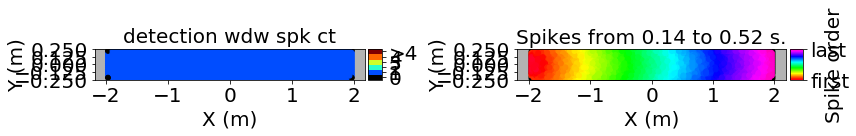

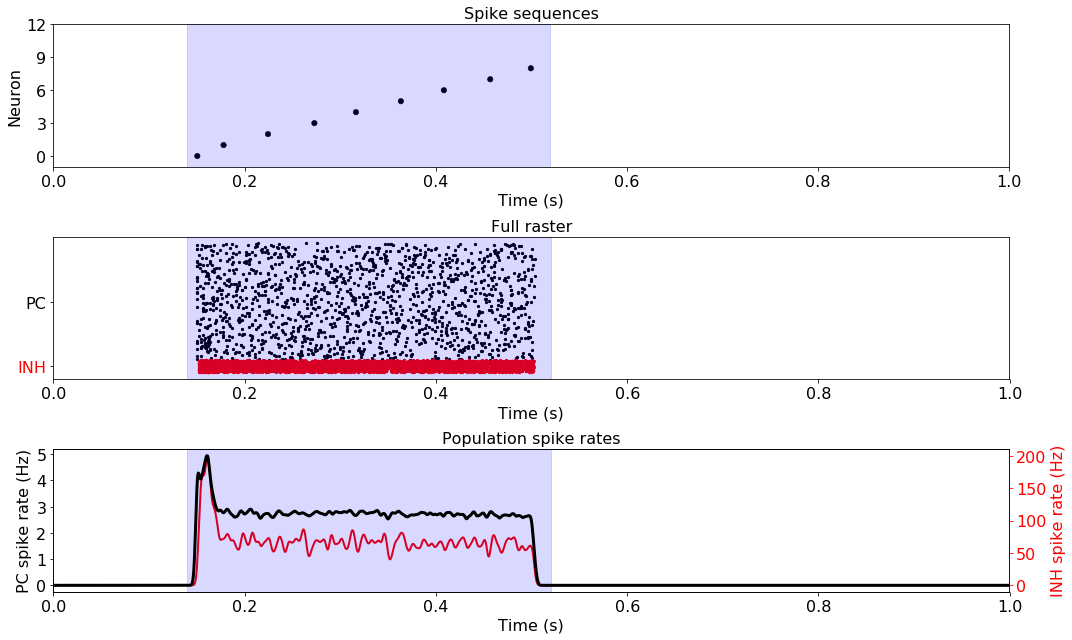

In [6]:
# run smln
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 0

print('Running smln...')
rslt = smln_run(m_params, s_params)
print('Smln complete.')

# make plots
XYS_RASTER = [
    (-2, 0), (-1.5, 0), (-1, 0), (-.5, 0), (0, 0), (.5, 0), (1, 0), (1.5, 0), (2, 0)
]
EPOCHS = [(.14, .52)]

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, axs = plot_spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot_raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 1),
    trg_plt=[],
    y_lim=(-1, 9),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)